In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('/content/sample_data/formspring_data.csv',delimiter='\t',quoting=3)

In [4]:
df = df[['ques','ans1']]  #limiting to question and answer 
#replacing html symbols
df['ques'] = df['ques'].str.replace('&#039;',' ')
df['ques'] = df['ques'].str.replace('&quot;',' ')
df['ques'] = df['ques'].str.replace('<br>',' ')    

In [6]:
df = df.dropna()
positives = df[df['ans1']=='Yes']
negatives = df[df['ans1']=='No']
frames = [positives,negatives]

In [7]:
df = pd.concat(frames)
df = df.sample(frac=1)

In [8]:
df['ans1'] = df['ans1'].replace(('Yes','No'),(1,0))
bag = []
def clean_data(sentence):
    sentence = re.sub('[^a-zA-Z]',' ',sentence)
    sentence = sentence.lower().split()
    words = [word for word in sentence if not word in stopwords.words('english')]
    sentence = ' '.join(words)
    bag.append(sentence)

In [9]:
df['ans1'].value_counts()

0    11691
1     1038
Name: ans1, dtype: int64

In [10]:
import re
df['ques'].apply(clean_data)

10556    None
3923     None
3513     None
5990     None
1437     None
         ... 
3891     None
1022     None
7623     None
9130     None
10053    None
Name: ques, Length: 12729, dtype: object

In [11]:
tokenizer = Tokenizer(num_words=20000)

In [12]:
X = df['ques'].values
tokenizer.fit_on_texts(X)
print(tokenizer.word_index)

{'you': 1, 'i': 2, 'a': 3, 'the': 4, 'to': 5, 'do': 6, 'what': 7, 'your': 8, 'is': 9, 'and': 10, 'it': 11, 'have': 12, 'in': 13, 'of': 14, 'u': 15, 'or': 16, 'are': 17, 'if': 18, 'would': 19, 'that': 20, 'like': 21, 'on': 22, 'me': 23, 'how': 24, 'be': 25, 'for': 26, 's': 27, 'ever': 28, 'my': 29, 'apos': 30, 'so': 31, 'why': 32, 'with': 33, 'who': 34, 'was': 35, 'think': 36, 'not': 37, 'r': 38, 'know': 39, 'lol': 40, 'when': 41, 't': 42, 'd': 43, 'love': 44, 'can': 45, 'one': 46, 'just': 47, 'about': 48, 'get': 49, 'but': 50, 'did': 51, 'up': 52, 'at': 53, '3': 54, 'people': 55, 'this': 56, 'im': 57, 'they': 58, 'go': 59, 'out': 60, 'ur': 61, 'all': 62, 'want': 63, 'were': 64, 'm': 65, 'there': 66, 'time': 67, 'someone': 68, 'now': 69, 'favorite': 70, 'haha': 71, 'had': 72, 'no': 73, 'from': 74, 'any': 75, 'as': 76, 'could': 77, 'p': 78, 'them': 79, 'last': 80, '39': 81, 'most': 82, 'say': 83, 'we': 84, 'been': 85, 'life': 86, 'person': 87, 're': 88, 'thing': 89, 'an': 90, 'really': 9

In [13]:
len(tokenizer.word_index)
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X,maxlen=250)

In [16]:
len(tokenizer.word_index)

12572

In [17]:
y = df['ans1'].values.astype(int)

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [20]:
kval = 10
itertot = 40
sigma = 1.2
itergd = 300
#init kmean
kmean = np.zeros((kval, len(X_train[0])))

In [22]:
import random
for i in range(kval):
	for j in range(len(kmean[0])):
		kmean[i,j] = random.uniform(min(X_train[:,j]),max(X_train[:,j]))

In [28]:
distmin = np.zeros((len(X_train)))
for i in range(itertot):
  print('iteration ',i)
  for j in range(len(distmin)):
		#determine euclid distance
    distall = np.sum((X_train[j] - kmean)**2.0, axis=1)**0.5
    distmin[j] = np.argmin(distall)

	#search new k mean
  for j in range(kval):
    clust = []
    for k in range(len(distmin)):
      if distmin[k] == j:
        clust.append(X_train[k])
    if len(clust) > 0:
      kmean[j] = np.mean(np.asarray(clust), axis=0)

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39


In [56]:


def transforminput(param, center):
	newinput = np.zeros((len(param), len(center))).astype('float32')
	for i in range(len(param)):
		for j in range(len(center)):
			newinput[i,j] = np.exp(-(np.sum((param[i] - center[j])**2.0)**0.5) / sigma**2.0)
	return newinput

def generatemodel(numparam):
  model = Sequential()
  model.add(Dense(1, input_dim=numparam, activation='sigmoid'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m, recall_m])
  return model

In [33]:
newinput = transforminput(X_train, kmean)

In [66]:
new_X_test = transforminput(X_test,kmean)

In [68]:
from tensorflow.keras.layers import Embedding
model = generatemodel(kval)

In [52]:
kval

10

In [43]:
y_train.shape,newinput.shape

((9546,), (9546, 10))

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.fit(newinput, y_train, batch_size=45, epochs=1, verbose=2, shuffle=True)	

213/213 - 0s - loss: 0.6138 - accuracy: 0.8131 - f1_m: 0.0194 - precision_m: 0.0106 - recall_m: 0.1268


In [64]:
from sklearn.metrics import roc_curve


In [67]:
y_pred = model.predict(new_X_test)

In [ ]:
results = np.array(results)

In [71]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

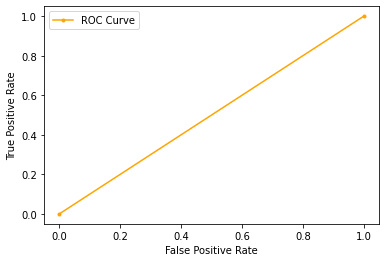

In [72]:
import matplotlib.pyplot as plt
plt.plot(fpr_keras, tpr_keras, marker='.', label='ROC Curve',color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()